In [1]:
# Common DS
import pandas as pd
import numpy as np
import scipy.stats as stats

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Helpful Stuff
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2

from splitter import splitter

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


----

# 1. Why it matters - 3pt shooting teams win!

Can we also show in general the percentage of teams that win when having a lower 3pt percentage?

In [ ]:
import explore

In [ ]:
past_ten = explore.winner_3pct()

In [ ]:
past_ten

> Key Takeaway - teams that win have a mean 3pt pct of 38.7% over the past 10 years, while those who lose average 32.3% from three (a 6.4% difference)

-----

# 2. Check to see if win_pct should be removed as a column, or if null rows should be removed instead.

##### Acquired 'tome_prep' modified to return win_prob in the dataframe.  Had to rest so this cannot be run and is more for demonstration purposes.

In [ ]:
from acquire import tome_prep

In [ ]:
df = tome_prep()

In [ ]:
df.info()
df.head()

In [ ]:
# Create column with or without win prob - then analyze differences
df['has_win_prob'] = np.where(df.win_prob.isnull() == False, 'has_win_prob','no_win_prob')

In [ ]:
y = 'abs_time'

In [ ]:
wp = df[df.has_win_prob == 'has_win_prob']
nwp = df[df.has_win_prob == 'no_win_prob']

In [ ]:
wp[y].max()

In [ ]:
plt.figure(figsize = (12,12))
sns.boxplot(data = df, x='has_win_prob',y=y)

##### This indicates that the time is cut off at a certain point, so I would rather lose this as a feature (when it afect is likely captures in point_margin) than lose those shots.

> ### Key Takeaway - Because win percentage calculation is turned off with 5 minutes (300 seconds) left in the game, and with no clean way to extrapolate it out accurately, we must drop this feature.

----

# 3. Correlation between features (heatmap)

##### Bring in split dataframes

In [2]:
from wrangle import wrangle_prep

In [23]:
df, df_outlier_3pt, X_train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_prep()

Train = 47167 rows (56.0%) | Validate = 20215 rows (24.0%) | Test = 16846 rows (20.0%)


#### Variable Exploration

In [24]:
exp = X_train_exp.copy()

In [25]:
exp.columns

Index(['player', 'player_id', 'team', 'team_id', 'game_id', 'home', 'period',
       'abs_time', 'play_time', 'since_rest', 'loc_x', 'loc_y', 'zone',
       'score_margin', 'points', 'shot_result', 'games_played', 'game_3pa',
       'game_3pm', 'game_3miss', 'cum_3pa', 'cum_3pm', 'cum_3miss', 'cum_3pct',
       'tm_v1', 'tm_v2', 'tm_v3', 'distance', 'game_event_id',
       'shot_made_flag'],
      dtype='object')

In [26]:
cont_cols = ['abs_time', 'play_time', 'since_rest','score_margin', 'points','games_played','cum_3pct','tm_v1', 'tm_v2', 'tm_v3', 'distance']

In [27]:
cat_cols = ['home', 'period','zone']

In [28]:
target = 'shot_result'

In [29]:
target_encoded = 'shot_made_flag'

### Heatmap:

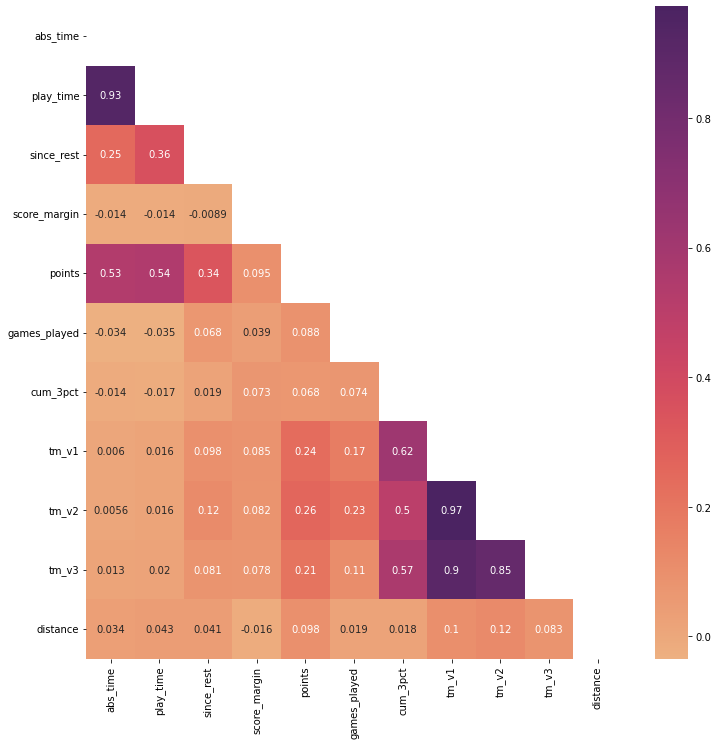

In [30]:
# Create a correlation matrix from the continuous numerical columns
df_cont_cols = exp[cont_cols]
corr = df_cont_cols.corr()

# Pass correlation matrix on to sns heatmap
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True, cmap="flare", mask=np.triu(corr))
plt.show()

> ### Heatmap Key Takeaway - Not counting the features that are similarly construced (cum_3pct, tm_v1 - tm_v3) or naturally correlated (points to abs_time and play_time) the standout feature is 'since_rest' that is correlated with our best metric, tm_v2, as well as points.

----

# 4. Categorical variables against target

### Step 1 - Plotting

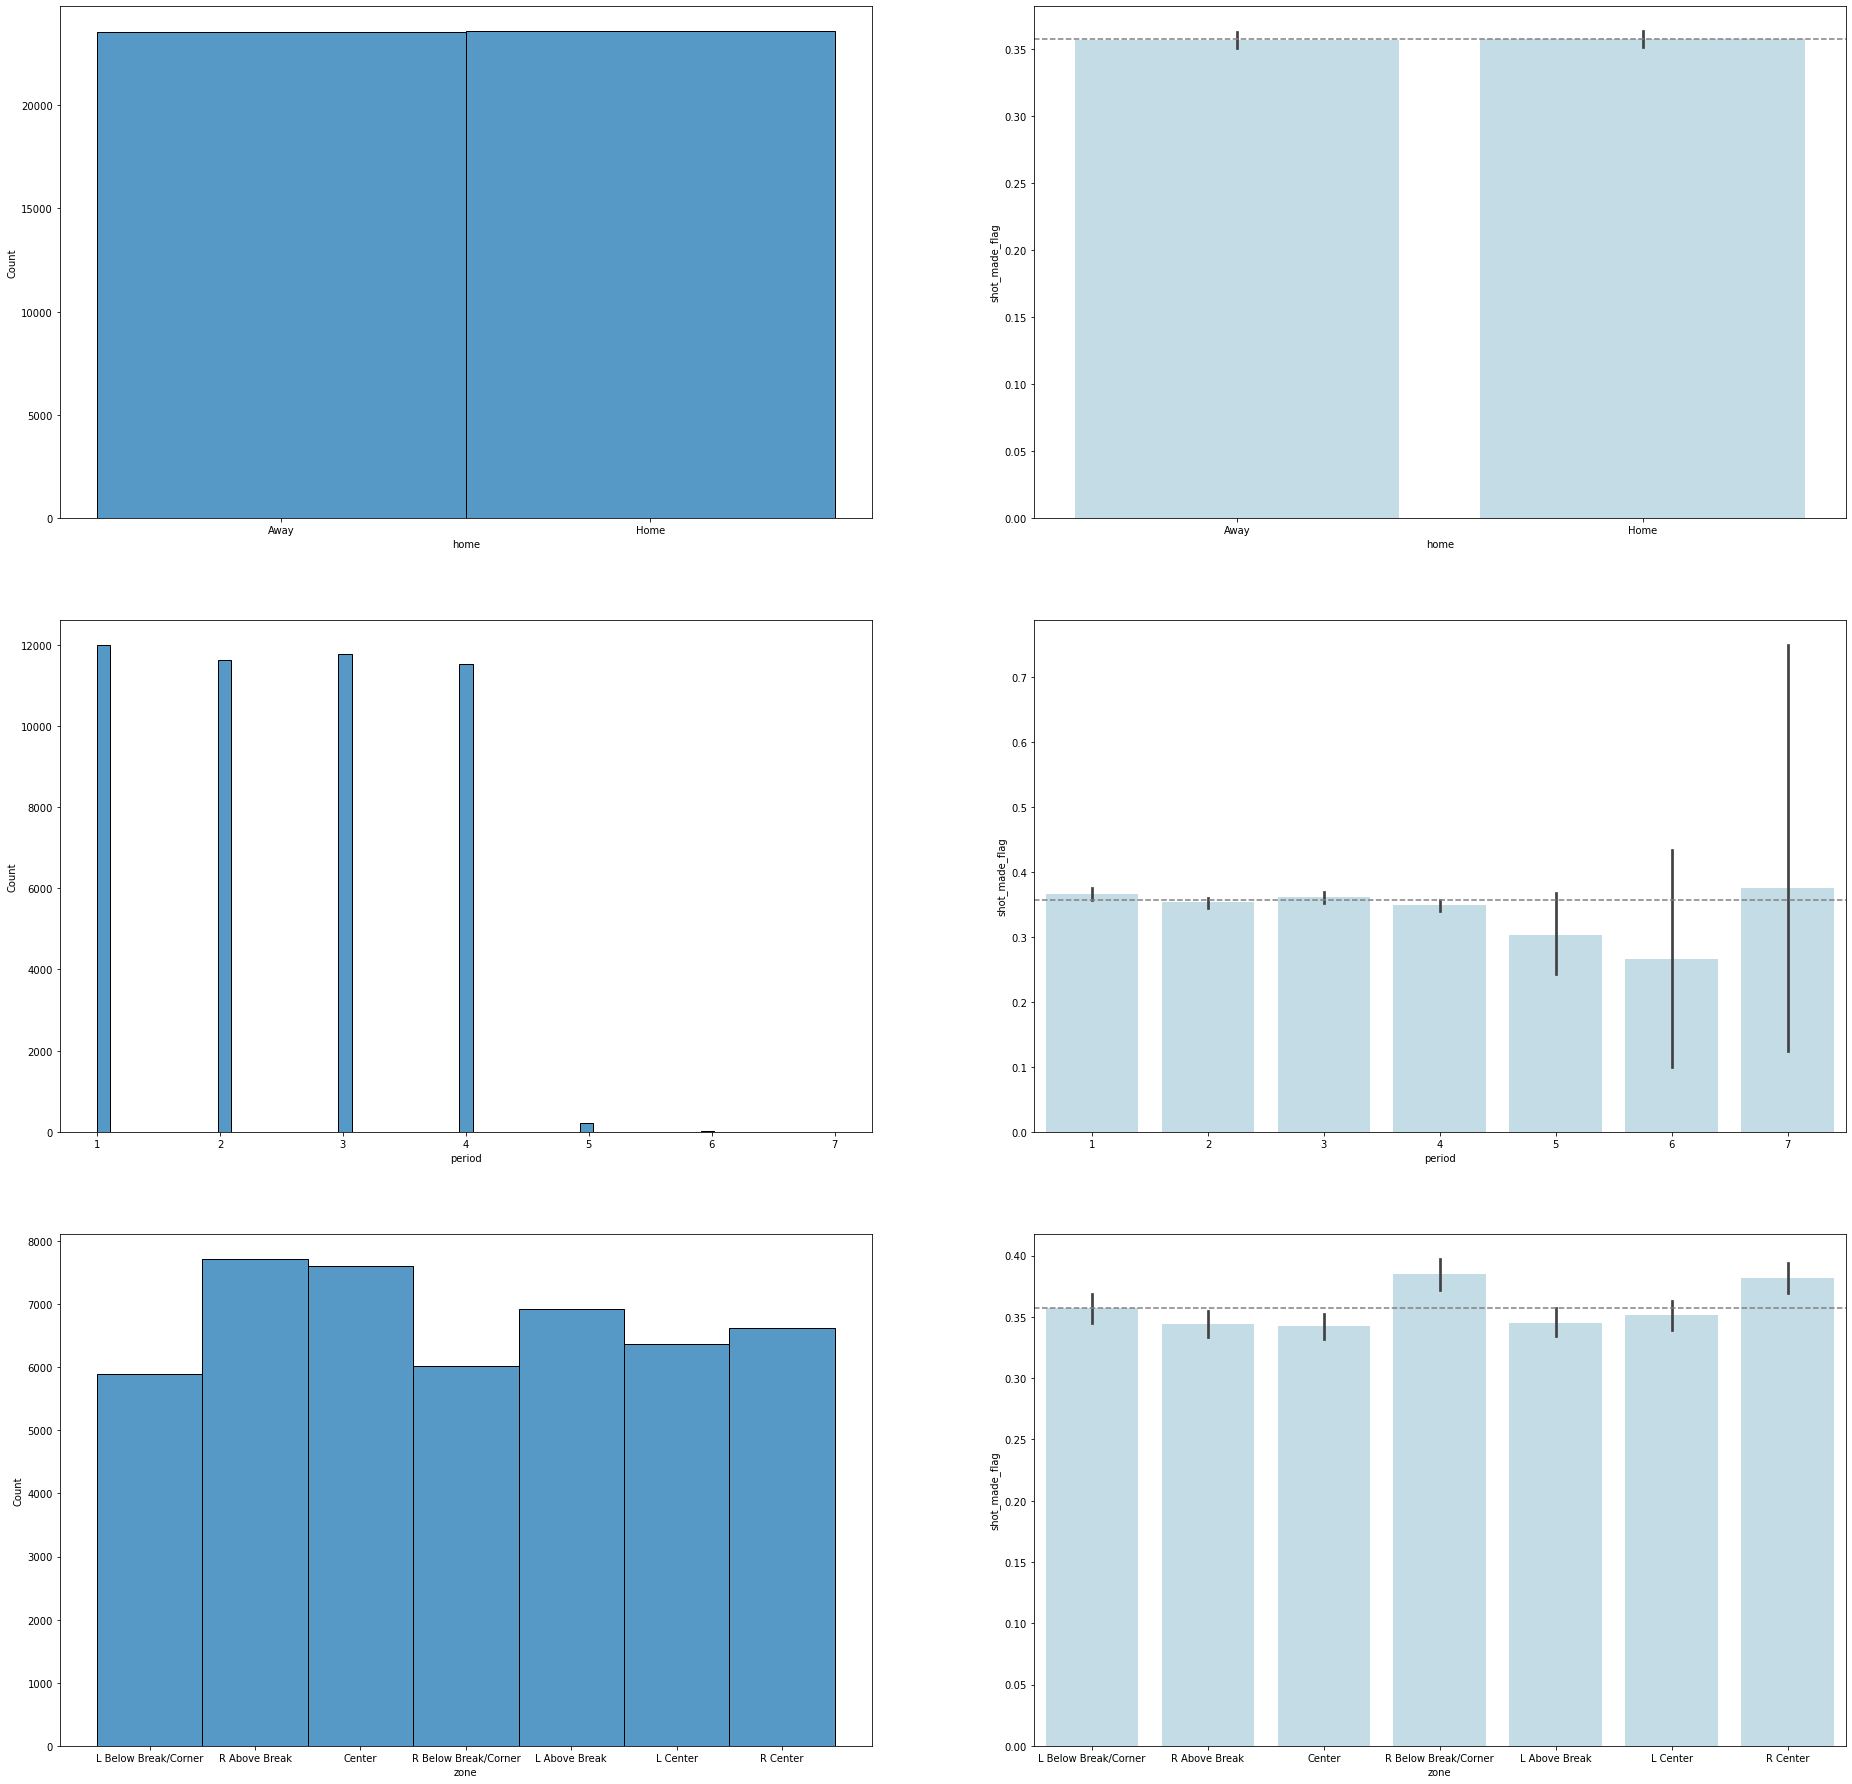

In [34]:
exp['home'] = np.where(exp.home == True, "Home","Away")
plt.figure(figsize=(32,32))
i=1
for col in cat_cols:
    plt.subplot(3, 2, i)
    sns.histplot(exp[col])    
    i+=1
    plt.subplot(3, 2, i)
    sns.barplot(x = col, y = target_encoded, data=exp, alpha=.8, color='lightblue')
    plt.axhline(exp[target_encoded].mean(), ls='--', color='gray')
    i+=1
plt.show()

### Step 2 - Run chi squared

In [57]:
# Set alpha:
a = .05

Home/Away vs. Shot Result:

In [59]:
observed = pd.crosstab(exp.home, exp.shot_result)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f'Chi-square = {chi2}')
if p < a:
    print(f'p = {p}, therefore, rejects the null hypothesis.')
else:
    print(f'p = {p}, therefore fail to reject the null hypothesis.')    

Chi-square = 0.027377924884132168
p = 0.8685797591403985, threfore the null hypothesis is confirmed.


> ### Key Takeaway - 3pt shooting percentage is independent of being on the road or at home.

Period vs. Shot Result

In [62]:
observed = pd.crosstab(exp.period, exp.shot_result)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f'Chi-square = {chi2}')
if p < a:
    print(f'p = {p}, therefore reject the null hypothesis.')
else:
    print(f'p = {p}, therefore fail to reject the null hypothesis.')    

Chi-square = 13.365956963162953
p = 0.03757892450567995, therefore reject the null hypothesis.


> ### Key Takeaway - there is a slight dependence of 3pt shooting on period, it appears mostly in the fourth quarter.  Overall, even though this fails to reject the null hypothesis, beyond saying 3pt shooting slightly ebbs in the fourth quarter we do not feel it is impactful.  We believe there may be more fourth quarter 'outlier' shots, outliers in that they aren't captured as outliers but are shots that are either rushed a bit to catch up in score if the player is down, or simply taken by a player when they are up big to practice a shot spot.

Zone vs. Shot Result

In [64]:
observed = pd.crosstab(exp.zone, exp.shot_result)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f'Chi-square = {chi2}')
if p < a:
    print(f'p = {p}, therefore, rejects the null hypothesis.')
else:
    print(f'p = {p}, therefore fail to reject the null hypothesis.')    

Chi-square = 54.89269600655561
p = 4.872613048323041e-10, therefore, rejects the null hypothesis.


> ### Key Takeaway - Looking at the chart, we see that hitting a 3pt shot is dependent on shooting location.  If shooting from below the break/corner on either side, players hit threes at or above average rate; right center is also a higher than mean probability shot.  A left center shot is within the confidence interval of the mean but on average is lower, and right above break, left above break and center are the lowest percentage of threes - althought they also represent the most threes shot so it could mean that defeneses have adjusted to those higher three point attempt zones - either because they know they are harder to hit, or because they know other shots, such as the corner, are easier to hit so they defend those places harder.

----

# 5. Continuous Variables Against Target

### Step 1 - Plotting

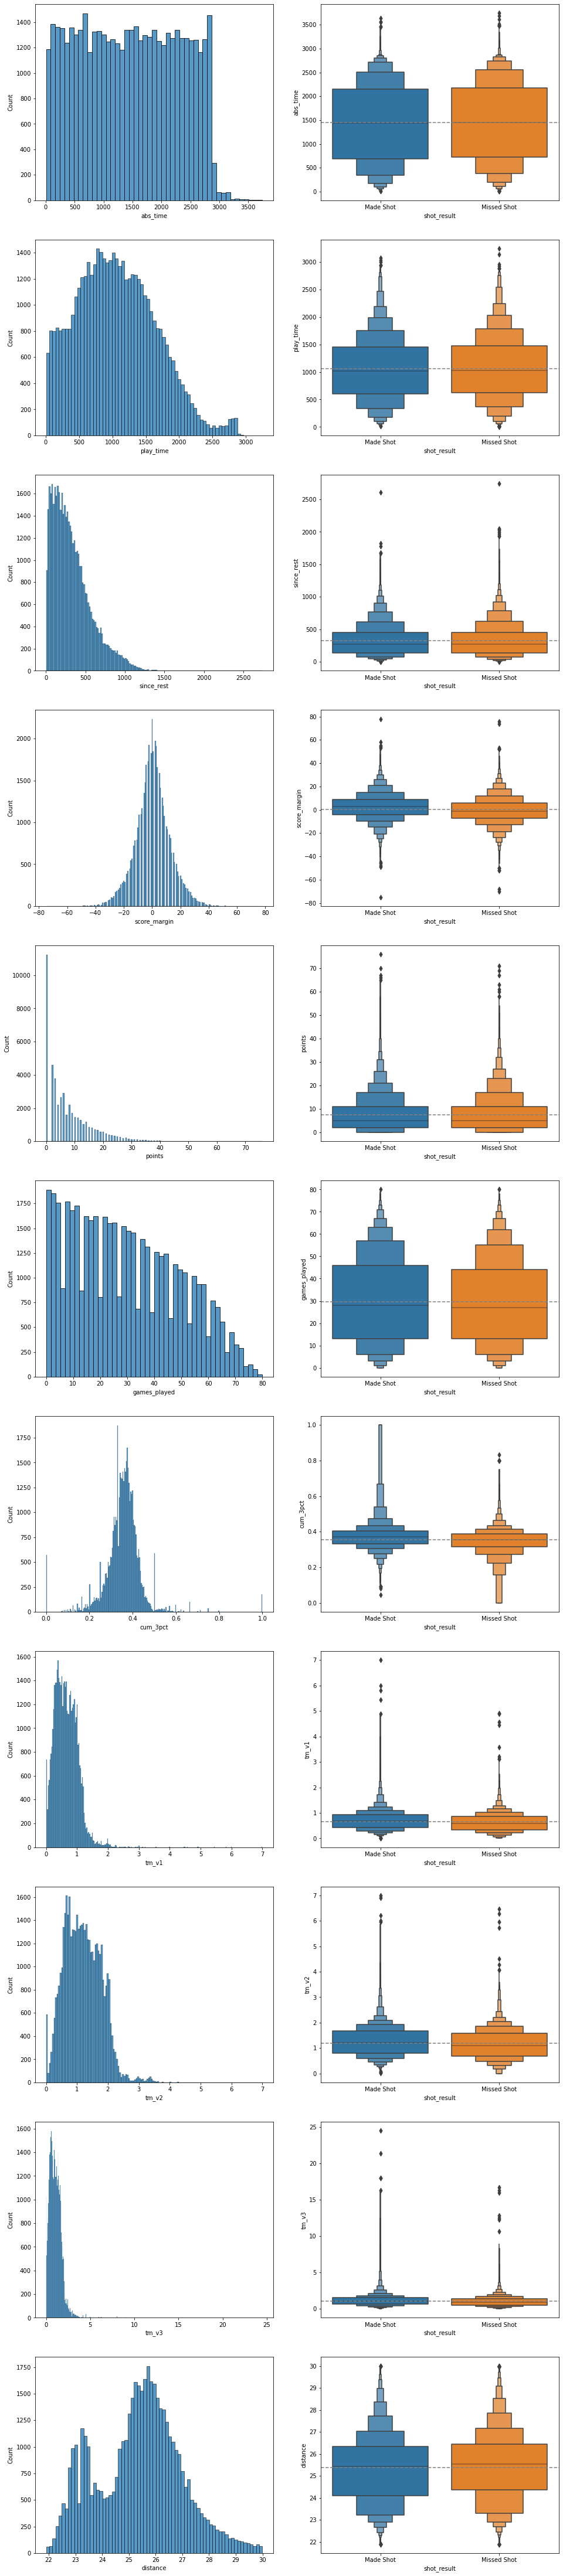

In [35]:
plt.figure(figsize=(16,80))
i=1
for col in cont_cols:
    plt.subplot(11, 2, i)
    sns.histplot(exp[col])
    i+=1
    plt.subplot(11, 2, i)
    sns.boxenplot(y = col, x = 'shot_result', data=exp)
    plt.axhline(exp[col].mean(), ls='--', color='gray')
    i+=1
plt.show()

### Step 2 - Based on the charts, run independent t-tests on following features: distance, tm_v2, since_rest, score_margin, games_played

##### First check t-test Assumptions:
- Indepedent? - YES, tm_v2 which includes 3pt shot data uses data from *before* the shot being analyzed.
- Normally Distributed? - YES, the only feature that isn't normally distributed is games played, but there are enough datapoints here to satisfy the central limit theorem.
- Equal variances? - Yes, all variances are close:

In [68]:
for i in ['distance','tm_v2','since_rest','score_margin','games_played']:
    print(f'{i} variances:','Made:',exp[exp.shot_result == 'Made Shot'][i].var(),' Missed:',exp[exp.shot_result == 'Missed Shot'][i].var())


distance variances: Made: 2.493132458256492  Missed: 2.508762250540079
tm_v2 variances: Made: 0.34168733122309514  Missed: 0.3569052547455416
since_rest variances: Made: 59764.81340611715  Missed: 62816.30713581885
score_margin variances: Made: 137.96665412462073  Missed: 141.42858078459133
games_played variances: Made: 392.53915795324485  Missed: 381.6564513199287


In [57]:
# Set alpha:
a = .05

Distance vs. Shot Result (one-sided t-test):

In [80]:
distance_made = exp[exp.shot_result == 'Made Shot'].distance
distance_missed = exp[exp.shot_result == 'Missed Shot'].distance
t, p = stats.ttest_ind(distance_made, distance_missed, equal_var=True)
print(f't = {t}')
if p/2 < a:
    print(f'p = {p}, therefore, rejects the null hypothesis.')
else:
    print(f'p = {p}, therefore fail to reject the null hypothesis.')

t = -7.177195052233609
p = 7.22023461387387e-13, therefore, rejects the null hypothesis.


> ### Key Takeaway - We reject that null hypothesis that shooting from a further distance has an equal or greater probability of hitting the shot than from shooting at a closer distance.  Therefore, players are better when shooting from a close distance (correlates with zones, as the below break/corner 3pt shots are at a closer distance.

TM_V2 vs. Shot Result (one-sided t-test):

In [81]:
tmv2made = exp[exp.shot_result == 'Made Shot'].tm_v2
tmv2missed = exp[exp.shot_result == 'Missed Shot'].tm_v2
t, p = stats.ttest_ind(tmv2made, tmv2missed, equal_var=True)
print(f't = {t}')
if p/2 < a:
    print(f'p = {p}, therefore, rejects the null hypothesis.')
else:
    print(f'p = {p}, therefore fail to reject the null hypothesis.')

t = 19.41388595983995
p = 1.250579162237694e-83, therefore, rejects the null hypothesis.


> ### Key Takeaway - We reject that null hypothesis that players who make shots have the same or lower tm_v2 score than those who miss shots.  Therefore tm_v2 score is a good indicator of whether a player hits a three point shot.

Time since rest vs. Shot Result (one-sided)

In [82]:
restmade = exp[exp.shot_result == 'Made Shot'].since_rest
restmissed = exp[exp.shot_result == 'Missed Shot'].since_rest
t, p = stats.ttest_ind(restmade, restmissed, equal_var=True)
print(f't = {t}')
if p/2 < a:
    print(f'p = {p}, therefore, rejects the null hypothesis.')
else:
    print(f'p = {p}, therefore fail to reject the null hypothesis.')

t = 0.05927963560613621
p = 0.952729632163387, therefore fail to reject the null hypothesis.


> ### Key Takeaway - We fail to reject the null hypothesis that players with the same or longer time since rest hit 3pt shots with the same percentage as those with less time since rest.  We strongly suspected that time since rest would have a negative impact on hitting a three, but looks like it does not.

Score Margin vs Shot Result (one-sided t-test)

In [83]:
scoremarginmade = exp[exp.shot_result == 'Made Shot'].score_margin
scoremarginmissed = exp[exp.shot_result == 'Missed Shot'].score_margin
t, p = stats.ttest_ind(scoremarginmade, scoremarginmissed, equal_var=True)
print(f't = {t}')
if p < a:
    print(f'p = {p}, therefore, rejects the null hypothesis.')
else:
    print(f'p = {p}, therefore fail to reject the null hypothesis.')

t = 28.22832375484482
p = 7.3878006985133915e-174, therefore, rejects the null hypothesis.


> ### Key Takeaway - We reject the null hypothesis that there is no difference in 3pt shot making ability when having a lower or the same score margin.  Therefore, when up in score, players seem to have more confidence in their shots, and hit more.

Games Played vs Shot Result (two-sided t-test)

In [84]:
gpmade = exp[exp.shot_result == 'Made Shot'].games_played
gpmissed = exp[exp.shot_result == 'Missed Shot'].games_played
t, p = stats.ttest_ind(gpmade, gpmissed, equal_var=True)
print(f't = {t}')
if p < a:
    print(f'p = {p}, therefore, rejects the null hypothesis.')
else:
    print(f'p = {p}, therefore fail to reject the null hypothesis.')

t = 4.590733982867856
p = 4.428279561594994e-06, therefore, rejects the null hypothesis.


> ### Key Takeaway - We reject the hypothesis that 3pt shooting is the same between players with different games played.  Players who play more games typically have a higher shot percetnage.  Makes sense since those playing more games are typically better shooters. Especially since our dataset is only 3pt shooters.

----

# * Player binning - To find elites using tm_v2 score

In [ ]:
# Create a Series of v2 scores, binned by player
tm_v2_scores = df.groupby('player').tm_v2.mean()
# Calculate the std and mean
stddev = tm_v2_scores.std()
meanscore = tm_v2_scores.mean()
# Create an elite cutoff score at two standard deviations above the mean
elites = meanscore + 2 * stddev
# Print the list of 'elite' players
tm_v2_scores[tm_v2_scores > elites].index

# ----------Below this line is scrapwork ----------

### Creating the metrics

In [ ]:
# Initialize game_id with the first player-game indexed in the dataframe
game_id = 22100014

# Need this to reset games counter
player_id = 203992

# Create lists to hold the running counts per player-game - these will become the columns
count_hold_3pm = []
count_hold_3pa = []
# games counter will change only when game changes
games_counter = []

# Initialize counters for player-game 3pa and 3pm
counter_3pm = 0
counter_3pa = 0
counter_games_played = 0

# Loop through each df row.  Since it goes through all of a player's games first, if the game_id is new it is a new player-game
for row in df.index:
    # If game is new, reset the counters
    if df.game_id[row] != game_id:
        counter_3pm = 0
        counter_3pa = 0
        # If player is new, reset this counter
        if df.player_id[row] != player_id:
            counter_games_played = 0
            player_id = df.player_id[row]
        else:
            counter_games_played += 1
    counter_3pa += 1
    if df['shot_result'][row] == 'Made Shot':
        counter_3pm += 1
    games_counter.append(counter_games_played)
    count_hold_3pm.append(counter_3pm)
    count_hold_3pa.append(counter_3pa)
    game_id = df.game_id[row]

df['games_played'] = games_counter
df['game_3pa'] = count_hold_3pa
df['game_3pm'] = count_hold_3pm    

In [ ]:
df['game_3miss'] = df['game_3pa'] - df['game_3pm']

In [ ]:
df.head(20)

Now let's do some running stats on the df:

In [ ]:
# Initialize game_id with the first player-game indexed in the dataframe
player_id = 203992

# Create lists to hold the running counts per player-game - these will become the columns
to_date_season_3pm_hold = []
to_date_season_3pa_hold = []

# Initialize counters for player-game 3pa and 3pm
counter_3pm = 0
counter_3pa = 0

# Loop through each df row.  Since it goes through all of a player's games first, if the game_id is new it is a new player-game
for row in df.index:
    # If game is new, reset the counters
    if df.player_id[row] != player_id:
        counter_3pm = 0
        counter_3pa = 0
    counter_3pa += 1
    if df['shot_result'][row] == 'Made Shot':
        counter_3pm += 1
    to_date_season_3pm_hold.append(counter_3pm)
    to_date_season_3pa_hold.append(counter_3pa)
    player_id = df.player_id[row]
    
df['to_shot_3pa'] = to_date_season_3pa_hold
df['to_shot_3pm'] = to_date_season_3pm_hold 
df['to_shot_3miss'] = df['to_shot_3pa'] - df['to_shot_3pm']

In [ ]:
# Three metric v1 is made^2 / attempts
df['tm_v1'] = (df.to_shot_3pm**2 / df.to_shot_3pa)/(df.games_played + 1)

In [ ]:
# Three metric v2 is made * [(1 - (made/attempts)) / 2 + (made / attempts)
df['tm_v2'] = (df.to_shot_3pm * (( 1 - (df.to_shot_3pm/df.to_shot_3pa))/2 + (df.to_shot_3pm/df.to_shot_3pa))) / (df.games_played + 1)

In [ ]:
# Three metric v3 is made^2/miss
df['tm_v3'] = (df.to_shot_3pm**2 / df.to_shot_3miss) / (df.games_played + 1)

In [ ]:
df['tm_v3'] = np.where(df['tm_v3'] == np.inf, 0, df['tm_v3'])

In [ ]:
df.describe()

In [ ]:
sns.histplot(df.tm_v1)

In [ ]:
sns.histplot(df.tm_v2)

In [ ]:
sns.histplot(df.tm_v3)

In [ ]:
df.sort_values('tm_v2', ascending = False)

In [ ]:
df_pm = df[df.player == "Patty Mills"]

In [ ]:
df_pm

In [ ]:
df_sc = df[df.player == 'Stephen Curry']

In [ ]:
df_sc.groupby('games_played').tm_v2.mean().plot()
df_pm.groupby('games_played').tm_v2.mean().plot()

In [ ]:
# shots attempted, play time 
b

#df['3pa_bin'] = pd.cut(df.shot_attempted_flag, bins = [0, 4, 10, 15, 21], labels = ['0-4 shots', '5-9 shots', '10-14 shots','15-20 shots']) # creating age bins 
dfdf["minutes_bin"] = pd.cut(df.play_time, bins = [0, 400, 1000, 1500, 1999, 3000], labels = ['below 400 minutes', '400-1000 minutes', '1000-1500 minutes','1500-2000 minutes', '2000 to 3000 minutes'])

In [ ]:
df_core = pd.read_csv('all_last_season_shots_3pt_clusters.csv')

In [ ]:
df_core.

In [ ]:
from nba_api.stats.endpoints import leaguegamefinder

In [ ]:
leaguegamefinder.LeagueGameFinder(SEASON_ID == 22022).get_data_frames()[0]